In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from scipy.stats import norm
from sklearn.mixture import GaussianMixture as GMM
from scipy import stats

### Data Input

In [130]:
#load data
d = pd.read_csv('defLanB1_300817_frame200-400.csv')
# (I renamed first Time column to Absolute Time)

window = 20  # set size of window
step_sizes = [1, 2, 3, 4, 5, 6, 7, 8]  # downsampling step sizes

# only keep data for tracks with more points than the window size even at the greatest downsampling rate
#tracks_to_keep = d[ (d['Time']//max(step_sizes)) > (window+1) ]['TrackID']  # wrong!
tracks_to_keep = d.TrackID.value_counts().loc[lambda x: (x//max(step_sizes) > (window+1))].reset_index()['index']
data = d[d['TrackID'].isin(tracks_to_keep)]

# select subset of data to work with to reduce computation time
data = d[d['TrackID'].isin(tracks_to_keep)] 

print(tracks_to_keep)
print(len(data))

# print number of tracks
ntracks = len(np.unique(tracks_to_keep))
print('number of tracks: {}'.format(ntracks))

#data = d[d['TrackID']==1000000043]  # select single track

0     1000000295
1     1000000118
2     1000000056
3     1000000248
4     1000000173
         ...    
61    1000000085
62    1000121078
63    1000121654
64    1000122642
65    1000123369
Name: index, Length: 66, dtype: int64
12998
number of tracks: 66


In [131]:
data

,Position X,Position Y,Position Z,Unit,TrackID,ID,Absolute Time,Unit.1,Time
43,138.3050,329.4120,11.8544,um,1000000043,43,0.0,s,1
56,92.4796,501.9870,15.3209,um,1000000056,56,0.0,s,1
62,30.0257,107.1690,18.2944,um,1000000062,62,0.0,s,1
70,45.3700,95.1516,22.1999,um,1000000070,70,0.0,s,1
77,25.1511,169.0380,25.3268,um,1000000077,77,0.0,s,1
...,...,...,...,...,...,...,...,...,...
113859,39.6756,268.9090,65.5503,um,1000000325,226299,3520.0,s,201
113864,30.2338,296.0400,66.6750,um,1000118407,226304,3520.0,s,201
113865,27.5918,303.9520,66.3799,um,1000117908,226305,3520.0,s,201
113885,72.4325,308.3700,70.5000,um,1000000330,226325,3520.0,s,201


### Displacements and exponent prediction

In [132]:
#load neural network model
model = tf.keras.models.load_model("model3dense_n{}.h5".format(window))

def find_displacement(x_data, y_data, z_data, start_index=0):
#calculate displacements 
    #x_data = np.array(x_data.data)
    #y_data = np.array(y_data.data)
    disps = np.sqrt(np.power(x_data-x_data[0],2) + np.power(y_data-y_data[0],2) + np.power(z_data-z_data[0],2))
    
    return disps 


def estimate_hurst(disps, time, window):
    
    h = np.array([])
    ht = np.array([])
    for i in range(int(window/2), len(disps)-int(1+window/2)):
        #sample of 20 points to calculate hurst exponent for
        inx = disps[(i-int(window/2)):(i+int(1+window/2))]
        #apply differencing and normalization on the data
        inx = np.array([(inx[1:]-inx[0:-1])/(np.amax(inx)-np.amin(inx))])
        test = model.predict(inx,verbose=0)
        h=np.append(h,test[0][0])
        ht = np.append(ht,time[i])
        
    return h,ht

### Downsampling and averaging

In [133]:
def downsample(data_input, down_int, start_index=0):
    
    data_out = data_input.iloc[start_index::down_int]
    return data_out


def dsample_est_hurst(data_in, ds_rate, window):
    """
    Args:
        data_in: pandas dataframe
        ds_rate: int, downsampling step size
    Returns:
        h_arr: 2D np array
        ht_arr: 2D np array
    """
    
    h_arr = np.empty((ds_rate,(len(data_in)//ds_rate)-(window+1)))
    ht_arr = np.empty((ds_rate,(len(data_in)//ds_rate)-(window+1)))
    
    for i in np.arange(ds_rate):
        
        downsampled_data = downsample(data_in, ds_rate, i)
        x = np.array(downsampled_data['Position X'])
        y = np.array(downsampled_data['Position Y'])
        z = np.array(downsampled_data['Position Z'])
        t = np.array(downsampled_data['Absolute Time'])
        displacements = find_displacement(x,y,z)
        h,ht = estimate_hurst(displacements, t, window)
        
        if len(h)>np.shape(h_arr)[1]:
            h=h[:-1]
            ht=ht[:-1]
            
        h_arr[i] = h
        ht_arr[i] = ht
        
    return h_arr,ht_arr


def average_hurst(h_arr, ht_arr):
    """
    """
    h_average_arr = np.mean(h_arr, axis=0)
    ht_average_arr = np.mean(ht_arr, axis=0)
    
    return h_average_arr, ht_average_arr

In [139]:
def filter_data(data_in, step_size, window):
    """
    Only keeps data for tracks that are long enough for hurst exponent estimation at a given downsampling step size.
    Args: 
        data_in: pandas dataframe, original data
        step_size: int, downsampling step size
        window: int, size of rolling window for hurst component estimation
    Returns:
        filtered_data: pandas dataframe
    """
    tracks_to_keep = data_in.TrackID.value_counts().loc[lambda x: (x//max(step_sizes) > (window+1))].reset_index()['index']
    filtered_data = data_in[data_in['TrackID'].isin(tracks_to_keep)]
    return filtered_data

In [140]:
def get_h_values(data_in, step_size, window):
    """
    Args:
        data: pandas dataframe, original data
    Returns 1D array of (mean) hurst exponent values for a given step size.
    """
    # filter data to keep only tracks that are long enough for H estimation
    data = filter_data(data_in, step_size, window)
    
    track_id_values = np.unique(data['TrackID'])
    
    h = np.array([])
    for tid in track_id_values:
        track_data = data[data['TrackID']==tid]
        h_arr, ht_arr = dsample_est_hurst(track_data, s, window)  
        h_av_arr, ht_av_arr = average_hurst(h_arr, ht_arr)  
        h = np.append(h, h_av_arr)
        
    return h

In [ ]:
def get_hht_avg_dict(data_in, step_sizes):
    """
    """
    h_av_dict = {}
    ht_av_dict = {}
    
    for i, s in enumerate(step_sizes):
        h_arr, ht_arr = dsample_est_hurst(data_in, s)
        h_av_arr, ht_av_arr = average_hurst(h_arr, ht_arr)
    
        h_av_dict["{}".format(s)] = h_av_arr.tolist()
        ht_av_dict["{}".format(s)] = ht_av_arr.tolist()
        
    return h_av_dict, ht_av_dict


def get_hist_h(h_av_dictionary, nbins):
    
    keys_list = list(h_av_dictionary)
    
    normalised_counts_all = np.empty((len(keys_list), nbins))
    bins_all = np.empty((len(keys_list), nbins+1))
    
    for i,key in enumerate(keys_list):
    
        counts, bins = np.histogram(h_av_dictionary[key], nbins)
        normalised_counts = counts/len(h_av_dictionary[key])
        normalised_counts_all[i] = normalised_counts
        bins_all[i] = bins
    
    return normalised_counts_all, bins_all

In [134]:
def plot_hist_2D(data, step_sizes, nbins, window):
    """
    
    """
    track_id_values = np.unique(data['TrackID'])
    
    # plot histogram for each downsampling step size
    for s in step_sizes:
        # compute H values for each track and put them all in one array
        h = np.array([])
        for tid in track_id_values:
            track_data = data[data['TrackID']==tid]
            h_arr, ht_arr = dsample_est_hurst(track_data, s, window)  
            h_av_arr, ht_av_arr = average_hurst(h_arr, ht_arr)  
            h = np.append(h, h_av_arr)
        plt.hist(h, nbins, density=True, label='step size = {}'.format(s))  
        # density=True for normalisation so that area under histogram integrates to 1
    plt.legend()
    plt.xlabel('H')
    plt.ylabel('p(H)')
    plt.show()
        

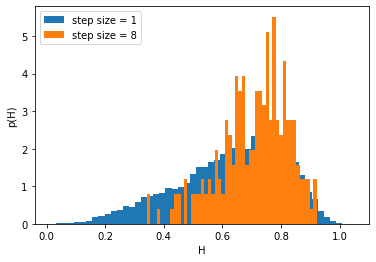

In [136]:
nbins = 50
plot_hist_2D(data, [1, 8], nbins, window)

In [ ]:
h2,ht2 = dsample_est_hurst(data,2, window)

In [45]:
h3,ht3 = dsample_est_hurst(data,3, window)

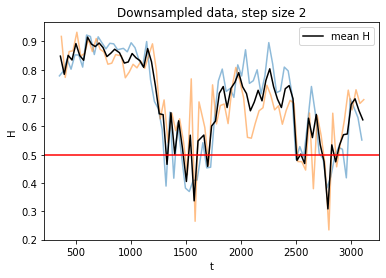

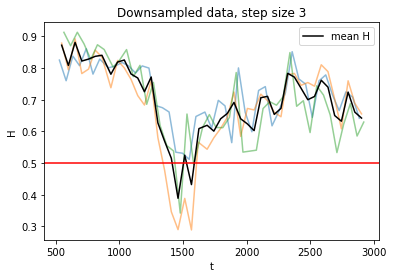

In [46]:
def plot_downsampled_hurst(h_arr, ht_arr):
    """
    """
    h_av_arr, ht_av_arr = average_hurst(h_arr, ht_arr)
    
    for i in np.arange(len(h_arr)):
        plt.plot(ht_arr[i], h_arr[i], alpha=0.5)
    plt.plot(ht_av_arr, h_av_arr, label='mean H', color='k')
    plt.axhline(0.5, c='r')
    plt.xlabel('t')
    plt.ylabel('H')
    plt.title('Downsampled data, step size {}'.format(len(h_arr)))
    plt.legend()
    plt.show()
    
plot_downsampled_hurst(h2, ht2)
plot_downsampled_hurst(h3, ht3)

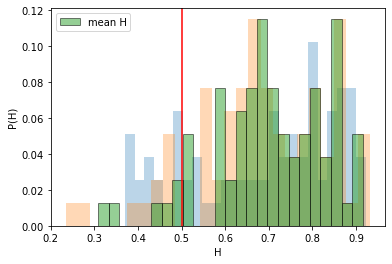

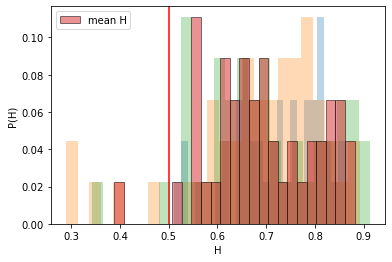

In [47]:
def plot_hist_2D(h_arr, ht_arr, nbins):
    """
    """
    for i in np.arange(len(h_arr)):
        counts, bins = np.histogram(h_arr[i], nbins)
        normalised_counts = counts/len(h_arr[i])  # normalisation so total counts = 1
        plt.hist(bins[:-1], bins, weights=normalised_counts, alpha=0.3)
        
    h_av_arr, ht_av_arr = average_hurst(h_arr, ht_arr)
    counts_av, bins_av = np.histogram(h_av_arr, nbins)
    normalised_counts_av = counts/len(h_av_arr)
    plt.hist(bins_av[:-1], bins_av, weights=normalised_counts_av, label='mean H', alpha=0.5, ec='black')
    
    plt.xlabel('H')
    plt.ylabel('P(H)')
    plt.axvline(0.5, color='r')
    plt.legend()
    plt.show()

%matplotlib inline
plt.figure()
plot_hist_2D(h2, ht2, 25)
plot_hist_2D(h3, ht3, 25)
plt.show()

### 3D histogram

3D histogram:<br>
x axis is H.<br>
y axis is step size used for that downsampled data set.<br>
z axis is normalised average counts.<br>

In [51]:
def get_3D_hist_data(data_in, step_sizes, nbins, window):
    """
    Args:
        data_in: pandas dataframe
        step_sizes: array of int
        nbins: int, number of histogram bins
    Returns:
        normalised_counts_all: 2D np array, each row is normalised average counts for a given step size
        bins_all: 2D np array, each row is bin edges for a given step size
    """
    normalised_counts_all = np.empty((len(step_sizes), nbins))
    bins_all = np.empty((len(step_sizes), nbins+1))
    
    for i, s in enumerate(step_sizes):
        h_arr, ht_arr = dsample_est_hurst(data_in, s, window)
        h_av_arr, ht_av_arr = average_hurst(h_arr, ht_arr)
        counts, bins = np.histogram(h_av_arr, nbins)
        normalised_counts = counts/len(h_av_arr)
        normalised_counts_all[i] = normalised_counts
        bins_all[i] = bins
        
    return normalised_counts_all, bins_all

In [54]:
nbins = 50
hist = get_3D_hist_data(data, step_sizes, nbins, window)

ValueError: negative dimensions are not allowed

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")

cmap = plt.cm.plasma

yticks = np.array(step_sizes)

for i, s in enumerate(step_sizes):
    ytick = yticks[i]
    normalised_counts = hist[0][i]
    bins = hist[1][i]
    xcenter = np.convolve(bins, np.ones(2), "valid")/2
    xwidth = np.diff(bins)
    ax.bar(left=xcenter, height=normalised_counts, width=xwidth, zs=ytick,
           zdir="y", color=cmap(i/len(yticks)), alpha=0.6, edgecolor="grey", linewidth=0.3)
    
ax.set_xlabel("H")
ax.set_ylabel("downsampling step size")
ax.set_zlabel("P(H)")

ax.set_yticks(yticks)
plt.show()

<IPython.core.display.Javascript object>


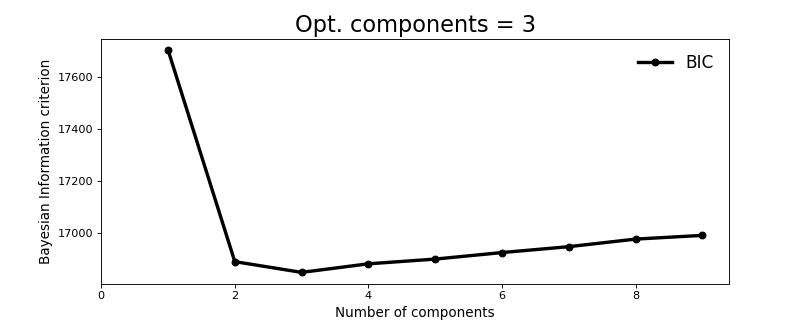

<IPython.core.display.Javascript object>


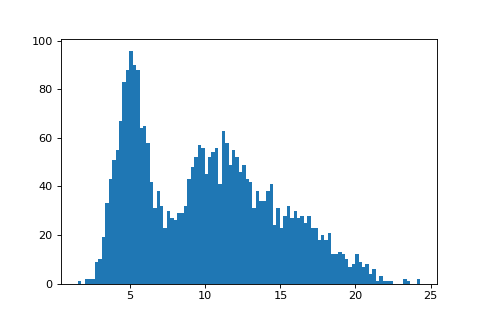

In [106]:
# first of all, let's confirm the optimal number of components
def optimum_components(data,n_max,plot=0):
    bics = []
    min_bic = 0
    counter=1
    for i in range (n_max-1): # test the AIC/BIC metric between 1 and 10 components
        gmm = GMM(n_components = counter, max_iter=1000, random_state=0, covariance_type = 'full')
        labels = gmm.fit(data).predict(data)
        bic = gmm.bic(data)
        bics.append(bic)
        if bic < min_bic or min_bic == 0:
            min_bic = bic
            opt_bic = counter
        counter +=1
    
    if plot==1:    
        fig,ax = plt.subplots(figsize=(10, 4))
        # Plot 1
        plt.plot(np.arange(1,n_max), bics, 'o-', lw=3, c='black', label='BIC')
        plt.legend(frameon=False, fontsize=15)
        plt.xlabel('Number of components', fontsize=12)
        plt.ylabel('Bayesian Information criterion', fontsize=12)
        plt.xticks(np.arange(0,n_max, 2))
        plt.title('Opt. components = '+str(opt_bic), fontsize=20)
        plt.show()

        
    return opt_bic,bics

data_temp = np.concatenate((np.random.normal(5, 1, 1000), np.random.normal(10, 2, 1000),np.random.normal(15, 3, 1000)))
data_temp = data_temp.reshape(-1, 1)   #hist[1][1].reshape(-1,1)
n_optimum,bic_vals = optimum_components(data_temp,10,plot=1)

fig,ax = plt.subplots()
plt.hist(data_temp,100)
plt.show()

<IPython.core.display.Javascript object>


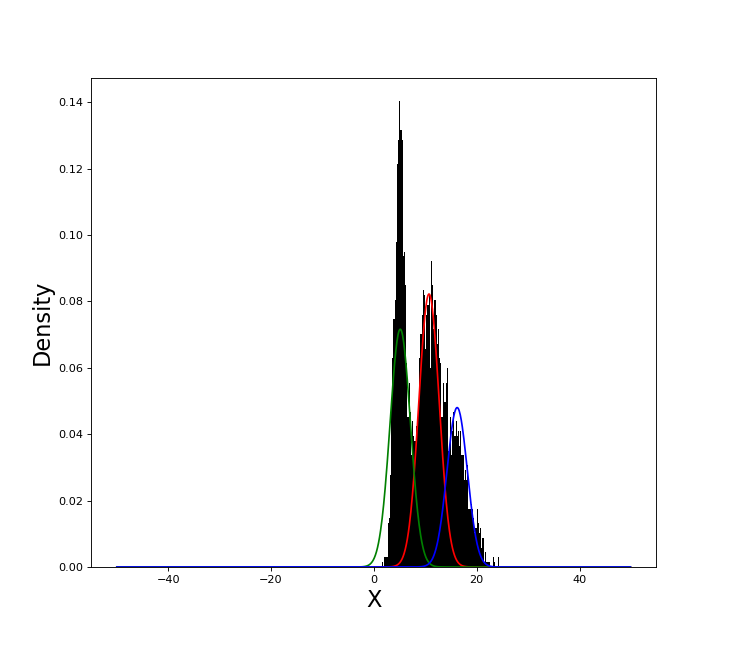

In [107]:
# create GMM model object
gmm = GMM(n_components = n_optimum, max_iter=1000, random_state=10, covariance_type = 'full')

# find useful parameters
mean = gmm.fit(data_temp).means_  
covs  = gmm.fit(data_temp).covariances_
weights = gmm.fit(data_temp).weights_

x_axis = np.arange(-50, 50, 0.1)

# create necessary things to plot
g1 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
g2 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[0][0][0])))*weights[1] # 1st gaussian
g3 = norm.pdf(x_axis, float(mean[2][0]), np.sqrt(float(covs[0][0][0])))*weights[2] # 1st gaussian

fig,ax = plt.subplots(figsize=(9,8))
# Plot 2
plt.hist(data_temp, density=True, color='black',bins=100)
plt.plot(x_axis, g1, c='r')
plt.plot(x_axis, g2, c='g')
plt.plot(x_axis, g3, c='b')
plt.xlabel(r"X", fontsize=20)
plt.ylabel(r"Density", fontsize=20)

plt.show()

## Meeting with Dr. Waigh 20/10/2022

Notes before meeting:
- Produced histograms of P(H) vs H for different downsampling steps
- Plotted in 3D, shows tendency to unimodal distribution, with high H , for high downsampling
- Displays trend to more directed behaviour
- Established code to find gaussian mixtures 

Next: 
- Upscale to treat full cohort of data, maybe average across for better stats?
- Finalise gaussian mixture and use with our data/3d plots

Questions:
- should we average displacement or H
- why would the histograms be different, training? 
- CNNS? wavenet?
- more detailed considerations, like sinusoidal fractal component and contact inhibition?

----------------------------------------------------------------------------------------------

Feedback:
- increase bin size, 2x bigger 
- count and normalise, not mean, area must be one overall
- plotting the tracks in 3D
- do with different mutants 
- look into normalisation for histograms 
- quantify differences when using model with code (CPU vs GPU)
- feature engineering issues , models fit scaling exponenent and alpha 
- haemocyte data 

Ideas: 
- Waigh mentioned developing models to account for what we observe, (sampling) time dependency of the P(h) distributions
- Trying to extend gaussian mixtures but for non-gaussian distributions, BIC over a wider model space?
- Machine learning for alpha and d-alpha 

Work plan: 
- Displacement 3D (Mila)
- Change normalisation and describe in markdown (Mila)
- Gaussian Mixture model applied to endosome data , not just example data ( Paul ) 
- Change to have just 2d histograms, perhaps 1, 3, 5,7,9,11  steps (Mila)
- Read in haemocuyte data and apply existing code
    - work on it together 20.10
    - contact t. millard about the track IDs and general structure of haemocyte data + mutant data set 
    